Extracting /tmp/tmpfnvtir/train-images-idx3-ubyte.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Extracting /tmp/tmpfnvtir/train-labels-idx1-ubyte.gz
Extracting /tmp/tmpfnvtir/t10k-images-idx3-ubyte.gz
Extracting /tmp/tmpfnvtir/t10k-labels-idx1-ubyte.gz
0 0.000812447992238 [-0.10490379  0.20937486 -0.03745797 -0.08013751  0.05707448  0.26724944
 -0.02373316  0.16307193 -0.38547993 -0.06505828]
1 0.000670490481637 [-0.15096277  0.25475293 -0.02313577 -0.11926677  0.06135206  0.46683329
 -0.03131013  0.25046128 -0.61695719 -0.09176741]
2 0.000790696035732 [-0.18910453  0.27472144 -0.00133357 -0.1469675   0.05725172  0.62787056
 -0.03981382  0.3263284  -0.7872206  -0.12173354]
3 0.000616496151144 [-0.22107971  0.30412924  0.01185172 -0.17160635  0.05190176  0.76594687
 -0.05277437  0.38481131 -0.92593002 -0.14725217]
4 0.000440059141679 [-0.25745949  0.30929235  0.03084355 -0.194474    0.04290669  0.88992393
 -0.06494599  0.45185822 -1.04119754 -0.16674975]
Optimization finished!
Accuracy: 0.9216
Label: [3]
Prediction: [3]


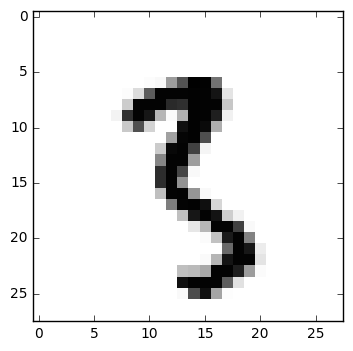

Label: [9]
Prediction: [9]


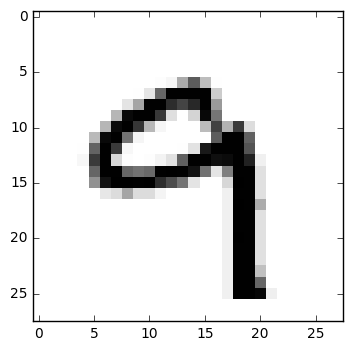

Label: [2]
Prediction: [2]


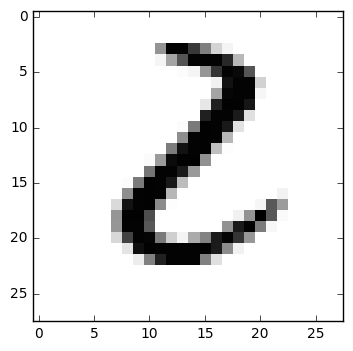

In [ ]:
import numpy, os, urllib, gzip, tempfile, random
import tensorflow as tf
import matplotlib.pyplot as plt


SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

VALIDATION_SIZE = 5000

def _read32(bytestream):
    dt = numpy.dtype(numpy.uint32).newbyteorder('>')
    return numpy.frombuffer(bytestream.read(4), dtype=dt)

def download(filename, workdir):
    if not os.path.exists(workdir):
        os.mkdir(workdir)

    filepath = os.path.join(workdir, filename)

    print 'Downloading', SOURCE_URL + filename
    urllib.urlretrieve(SOURCE_URL + filename, filename=filepath)
    return filepath

def extract_images(filepath):
    print 'Extracting', filepath
    with gzip.open(filepath) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' % (magic, filepath))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8)
        data = data.reshape(num_images, rows, cols, 1)

        # Reshape for NN
        data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
        data = data.astype(numpy.float32)
        data = numpy.multiply(data, 1. / 255.)
        return data

def extract_labels(filepath):
    print 'Extracting', filepath
    with gzip.open(filepath) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' % (magic, filepath))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)

        num_labels = labels.shape[0]
        num_classes = 10    # 0..9
        index_offset = numpy.arange(num_labels) * num_classes
        labels_one_hot = numpy.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return labels_one_hot

workdir = tempfile.mkdtemp()
train_images = extract_images(download(TRAIN_IMAGES, workdir))
train_labels = extract_labels(download(TRAIN_LABELS, workdir))
test_images = extract_images(download(TEST_IMAGES, workdir))
test_labels = extract_labels(download(TEST_LABELS, workdir))
validation_images = train_images[:VALIDATION_SIZE]
validation_labels = train_labels[:VALIDATION_SIZE]
train_images = train_images[VALIDATION_SIZE:]
train_labels = train_labels[VALIDATION_SIZE:]

assert len(train_labels) == len(train_images)
assert len(validation_labels) == len(validation_images)
assert len(test_labels) == len(test_images)
num_train_data = len(train_labels)
num_validation_data = len(validation_labels)
num_test_data = len(test_labels)


learning_rate = .1
training_epochs = 5
batch_size = 100

assert num_train_data % batch_size == 0

x = tf.placeholder("float", [None, 784])    # image of shape 28 x 28 = 784
y = tf.placeholder("float", [None, 10])     # 0..9 digits

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

activation = tf.nn.softmax(tf.matmul(x, W) + b)
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(activation), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):

        # Shuffle for each epoch
        perm = numpy.arange(num_train_data)
        numpy.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]

        average_cost = .0
        total_batch = int(num_train_data / batch_size)
        for i in range(total_batch):
            batch_xs = train_images[i*batch_size:(i+1)*batch_size]
            batch_ys = train_labels[i*batch_size:(i+1)*batch_size]
            sess.run(optimizer, feed_dict={x: batch_xs, y:batch_ys})

        average_cost += sess.run(cost, feed_dict={x: batch_xs, y:batch_ys}) / total_batch
        print epoch, average_cost, sess.run(b)

    print 'Optimization finished!'

    correct_prediction = tf.equal(tf.argmax(activation, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print 'Accuracy:', accuracy.eval({x: validation_images, y: validation_labels})

    for _ in range(10):
        # Get one and predict
        r = random.randint(0, num_test_data-1)
        print 'Label:', sess.run(tf.argmax(test_labels[r:r+1], 1))
        print 'Prediction:', sess.run(tf.argmax(activation, 1), {x: test_images[r:r+1]})

        # Show the image
        plt.imshow(test_images[r:r+1].reshape(28, 28), cmap='Greys', interpolation='nearest')
        plt.show()


# Clean up
import shutil
shutil.rmtree(workdir)